In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
#cargar los datos
dtype_spec_test = {
    'column_6_name': 'str',  # Replace 'column_6_name' with the actual name of column 6 in merged_test.csv
}

dtype_spec_train = {
    'column_7_name': 'str',  # Replace 'column_7_name' with the actual name of column 7 in merged_train.csv
}
train_eng = pd.read_csv('train_eng.csv', dtype=dtype_spec_test, low_memory=False)
test_eng = pd.read_csv('test_eng.csv', dtype=dtype_spec_test, low_memory=False)


In [1]:
# definir la métrica personalizada de rmspe con pesos
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1.0 / (y[ind] ** 2)
    return w

# función para calcular el rmspe
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe_value = np.sqrt(np.mean(w * (y - yhat) ** 2))
    return rmspe_value

# definir el custom scorer de rmspe para RandomizedSearchCV
def rmspe_scorer(y_true, y_pred):
    y_true = np.expm1(y_true)  # revertimos el log-transform en los valores reales
    y_pred = np.expm1(y_pred)  # revertimos el log-transform en las predicciones
    return rmspe(y_pred, y_true)

# cargar los datos de train y test
train_eng = pd.read_csv('train_eng.csv')
test_eng = pd.read_csv('test_eng.csv')

# asegurarse de que la columna 'date' esté en formato datetime
train_eng['date'] = pd.to_datetime(train_eng['date'])
test_eng['date'] = pd.to_datetime(test_eng['date'])

# eliminar columnas que no necesitamos
train_eng.drop(columns=['promo2_start_date'], inplace=True)
test_eng.drop(columns=['promo2_start_date'], inplace=True)

# identificar columnas no numéricas
non_numeric_cols = train_eng.select_dtypes(include=['object']).columns

# convertir las columnas no numéricas a numéricas (forzando errores a NaN)
for col in non_numeric_cols:
    train_eng[col] = pd.to_numeric(train_eng[col], errors='coerce')
    test_eng[col] = pd.to_numeric(test_eng[col], errors='coerce')

# separar las features (X) de la variable objetivo (y)
dep_var = 'sales'
X_train = train_eng.drop(columns=[dep_var, 'customers', 'date'])
y_train = np.log1p(train_eng[dep_var])  # aplicamos log-transform a la variable objetivo

# preparar los datos de test (sin 'sales', 'customers', 'date', y 'id')
X_test = test_eng.drop(columns=['sales', 'customers', 'date', 'id'], errors='ignore')

# manejar valores faltantes (rellenarlos con mediana o moda según corresponda)
for col in X_train.columns:
    if X_train[col].dtype in ['float64', 'int64']:
        X_train[col].fillna(X_train[col].median(), inplace=True)
        X_test[col].fillna(X_test[col].median(), inplace=True)
    else:
        X_train[col].fillna(X_train[col].mode()[0], inplace=True)
        X_test[col].fillna(X_test[col].mode()[0], inplace=True)

# dividir los datos en conjuntos de entrenamiento y validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# definir la grilla de parámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],  # número de árboles
    'max_depth': [10, 20, 30, None],  # profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # mínimo de muestras para hacer un split
    'min_samples_leaf': [1, 2, 4],  # mínimo de muestras por hoja
    'bootstrap': [True, False]  # si se usa bootstrap o no
}

# custom scorer para rmspe
rmspe_scorer = make_scorer(rmspe_scorer, greater_is_better=False)

# configurar RandomizedSearchCV para el Random Forest
rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, scoring=rmspe_scorer, cv=3, verbose=2, random_state=42, n_jobs=-1)

# entrenar el modelo usando RandomizedSearchCV
random_search.fit(X_train_split, y_train_split)

# obtener los mejores parámetros del search
best_rf_model = random_search.best_estimator_

# evaluar el modelo en el conjunto de validación
y_val_pred_rf = best_rf_model.predict(X_val_split)
val_rmspe_rf = rmspe(np.expm1(y_val_split), np.expm1(y_val_pred_rf))  # revertir el log-transform antes de calcular el rmspe
print(f'random forest validation rmspe: {val_rmspe_rf}')

# predecir sobre los datos de test
y_test_pred_rf = best_rf_model.predict(X_test)
y_test_pred_rf = np.expm1(y_test_pred_rf)  # revertir log-transform
y_test_pred_rf = np.maximum(0, y_test_pred_rf)  # las ventas no pueden ser negativas

# crear archivo de submission
test_ids = test_eng['id']  # ajustar según tu dataset
sample_submission_rf = pd.DataFrame({'Id': test_ids, 'Sales': y_test_pred_rf})
sample_submission_rf.to_csv('sample_submission_rf.csv', index=False)

print('archivo de submission guardado.')


/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_3267/58375182.py:28: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_eng = pd.read_csv('train_eng.csv')
/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_3267/58375182.py:29: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test_eng = pd.read_csv('test_eng.csv')
/var/folders/dk/_8pjx3z94934mw25lyqb9xkw0000gn/T/ipykernel_3267/58375182.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operatio

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=28.6min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=26.7min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=10.6min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=28.5min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=10.4min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=28.5min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=10.4min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total 

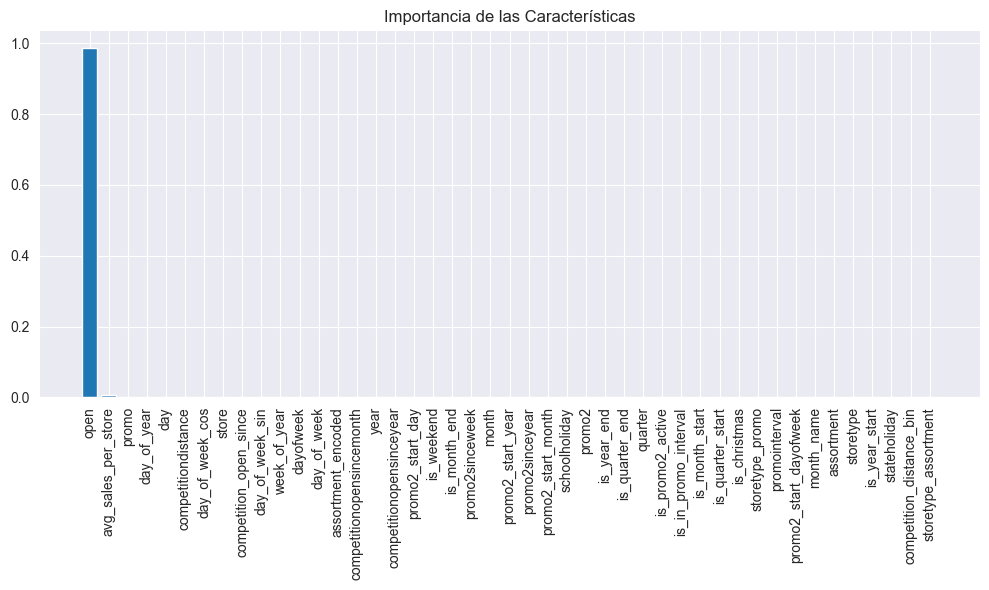

In [7]:
# mostrar el feature importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# selección de features importantes
threshold = 0.1  # Umbral de importancia
important_features = X_train.columns[importances >= threshold]
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

print(f"Las características seleccionadas son: {important_features}")

Las características seleccionadas son: Index(['open'], dtype='object')


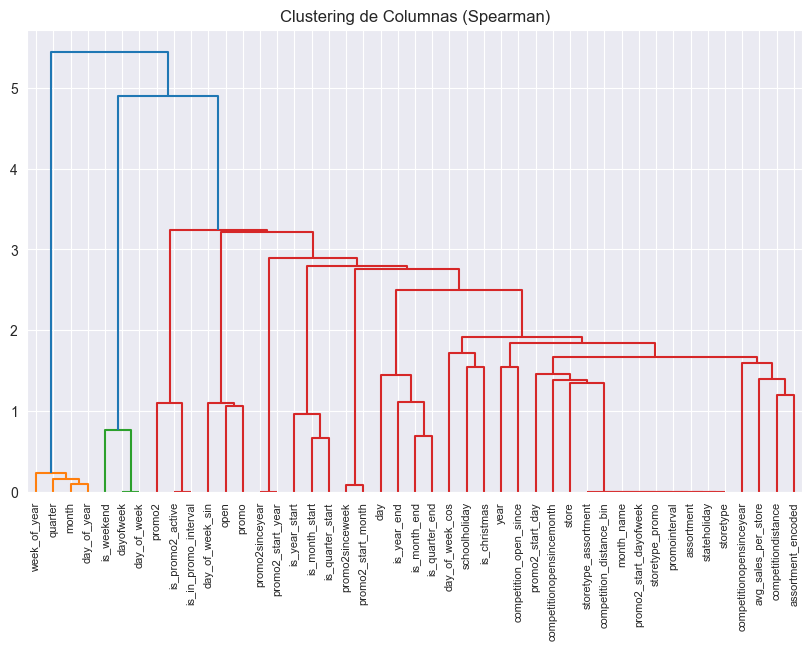

In [18]:
# clusterizacion usando la correlacion de Spearman
corr = X_train.corr(method='spearman')

# reemplazar nans 
corr = corr.replace([np.inf, -np.inf], np.nan).fillna(0)

Z = linkage(corr, 'ward')

# Plot del dendrograma
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=corr.columns, leaf_rotation=90)
plt.title("Clustering de Columnas (Spearman)")
plt.show()

# seleccionar columnas de acuerdo al clustering
max_d = 1.5  # distancia máxima para cortar el dendrograma
clusters = fcluster(Z, max_d, criterion='distance')
cluster_labels = np.unique(clusters)
selected_cols = []
for cluster_label in cluster_labels:
    cols = corr.columns[clusters == cluster_label]
    selected_cols.append(cols[0])  # seleccionar la primera columna de cada cluster

X_train_clustered = X_train[selected_cols]
X_test_clustered = X_test[selected_cols]